# Differential expression analysis
In this notebook we'll use `PyDESeq2` to perform differential expression analysis on the RNAseq data. We're going to follow [this tutorial](https://pydeseq2.readthedocs.io/en/stable/auto_examples/plot_minimal_pydeseq2_pipeline.html).

In [13]:
from os import listdir
import pandas as pd
import numpy as np
from functools import reduce
from pytximport import tximport
from pydeseq2.dds import DeseqDataSet
from pydeseq2.default_inference import DefaultInference
from pydeseq2.ds import DeseqStats
from pydeseq2.utils import load_example_data
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from collections import defaultdict

## Data pre-processing
Read in counts matrices:

In [14]:
kallisto_output_dir = '../data/kallisto_quant_bs'
sample_names = ["1h_2o2_e","1h_2o2_b","1h_2o2_c","1h_2o2_d",
"1h_21o2_a","1h_21o2_b","1h_21o2_c","1h_21o2_d",
"1h_40o2_a","1h_40o2_b","1h_40o2_c","1h_40o2_d",
"7h_2o2_a","7h_2o2_b","7h_2o2_c","7h_2o2_d",
"7h_21o2_a","7h_21o2_b","7h_21o2_c","7h_21o2_d",
"7h_40o2_a","7h_40o2_b","7h_40o2_c","7h_40o2_d"]
abundance_files = [f'{kallisto_output_dir}/{samp}/abundance.tsv' for samp in sample_names]

In [33]:
tx2gene = pd.read_csv('../data/AtRTD3_gene_transcript.csv').rename(columns={'TXNAME': 'transcript_id', 'GENEID':'gene_id'})
tx2gene.head()

,transcript_id,gene_id
0,AT1G01010.1,AT1G01010
1,AT1G01010.2,AT1G01010
2,AT1G01010.3,AT1G01010
3,AT1G01020.11,AT1G01020
4,AT1G01020.13,AT1G01020


In [19]:
abundance_res = tximport(
    abundance_files,
    data_type="kallisto",
    transcript_gene_map=tx2gene,
    id_column='target_id',
    counts_column='est_counts',
    length_column='eff_length',
    abundance_column='tpm'
)

Reading quantification files: 24it [00:01, 12.61it/s]
/mnt/home/lotrecks/.conda/envs/omics/lib/python3.10/site-packages/pytximport/utils/_remove_transcript_version.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transcript_target_map[id_column] = transcript_target_map[id_column].str.split(".").str[0]


#### NOTE:
Currently, pytximport and PyDESeq2 are not compatible the way the R implementations are, so I can't directly pipeline this tximport output into DESeq2 here. There [has been discussion](https://github.com/owkin/PyDESeq2/issues/359) about implementing this pipelining ability, but as of yet there hasn't been any work done on it. For now, in order to run the PCA and DE code in this notebook, a simpler method of reading in the abundances and adding the transcript together at the per gene level can be used (and is inplemented below); however, this produces drastically different results than using the normalization factors computed by tximport, and therefore the results can't be trusted. However, I've left the code below for the sake of being able to at least run the notebook until the pipelining between the packages is implemented.

In [26]:
abundance_dfs = {}
for d in listdir(kallisto_output_dir):
    abundance_dfs[d] = pd.read_csv(f'{kallisto_output_dir}/{d}/abundance.tsv', sep='\t')

Merge counts matrices into the format expected by DESeq2:

In [27]:
counts_df = reduce(lambda x, y: pd.merge(x, y, on='target_id'), [df[['target_id', 'est_counts']].rename(columns={'est_counts': k}) for k, df in abundance_dfs.items()]).set_index('target_id').T
counts_df = counts_df.astype('int')
counts_df.head()

target_id,AT1G01010.1,AT1G01010.2,AT1G01010.3,AT1G01020.11,AT1G01020.13,AT1G01020.14,AT1G01020.15,AT1G01020.16,AT1G01020.17,AT1G01020.18,...,ATMG09960.1,ATMG01360.1,ATMG09980.1,ATMG01370.1,ATMG01380.1,ATMG01390.1,G38195.1,ATMG01400.1,G38197.1,ATMG01410.1
7h_21o2_c,2,14,10,51,64,0,0,21,0,0,...,6,9217,30,1459,0,970,0,4,0,17
1h_40o2_b,0,0,14,72,13,23,9,16,0,0,...,1,6944,5,1162,0,765,0,10,0,10
1h_40o2_d,6,0,9,0,64,4,10,12,13,0,...,6,5660,12,967,1,733,0,11,0,5
7h_2o2_b,0,0,17,51,69,6,6,0,0,0,...,3,7925,11,1430,0,805,0,18,0,31
7h_2o2_a,0,33,0,31,101,23,4,0,27,13,...,0,8622,12,1792,1,871,0,14,0,27


We need to convert the transcript ID's into gene-level ID's. We have a csv file with a mapping loaded above that we just need to make into a dictionary of the correct format:

In [36]:
tx2gene_dict = tx2gene.set_index('transcript_id').to_dict()['gene_id']
gene2tx = defaultdict(list)
for k, v in tx2gene_dict.items():
    gene2tx[v].append(k)

In [37]:
combined_counts = {}
for k, v in gene2tx.items():
    combined_counts[k] = counts_df.loc[:, v].sum(axis=1)

In [38]:
counts_df = pd.DataFrame(combined_counts, index=counts_df.index)
counts_df.head()

,AT1G01010,AT1G01020,AT1G03987,AT1G01030,AT1G01040,AT1G01040-AT1G01046,AT1G03993,AT1G01046,AT1G01050,AT1G01050-AT1G01060,...,ATMG09960,ATMG01360,ATMG09980,ATMG01370,ATMG01380,ATMG01390,G38195,ATMG01400,G38197,ATMG01410
7h_21o2_c,26,160,2,60,27,170,0,0,290,0,...,6,9217,30,1459,0,970,0,4,0,17
1h_40o2_b,14,160,0,83,90,200,0,0,399,0,...,1,6944,5,1162,0,765,0,10,0,10
1h_40o2_d,15,103,1,117,83,116,0,0,305,0,...,6,5660,12,967,1,733,0,11,0,5
7h_2o2_b,17,192,0,65,0,259,0,0,455,0,...,3,7925,11,1430,0,805,0,18,0,31
7h_2o2_a,33,218,3,91,92,215,0,0,466,0,...,0,8622,12,1792,1,871,0,14,0,27


In order to use DESeq2, we need to create a metadata dataframe to accompany our counts matrix:

In [39]:
metadata = pd.DataFrame({'o2': counts_df.index.str.split('_').str[1], 'hour':counts_df.index.str.split('_').str[0]}, index=counts_df.index)
metadata.head()

,o2,hour
7h_21o2_c,21o2,7h
1h_40o2_b,40o2,1h
1h_40o2_d,40o2,1h
7h_2o2_b,2o2,7h
7h_2o2_a,2o2,7h


## Modeling

In [40]:
inference = DefaultInference(n_cpus=8)
dds = DeseqDataSet(
    counts=counts_df,
    metadata=metadata,
    design='~hour+o2+hour:o2',
    inference=inference,
)

In [41]:
dds.deseq2()

Using None as control genes, passed at DeseqDataSet initialization


Fitting size factors...
... done in 0.03 seconds.

Fitting dispersions...
... done in 33.93 seconds.

Fitting dispersion trend curve...
... done in 0.82 seconds.

Fitting MAP dispersions...
... done in 35.44 seconds.

Fitting LFCs...
... done in 31.69 seconds.

Calculating cook's distance...
... done in 0.05 seconds.

Replacing 0 outlier genes.



## PCA

Reproducing the following plot:

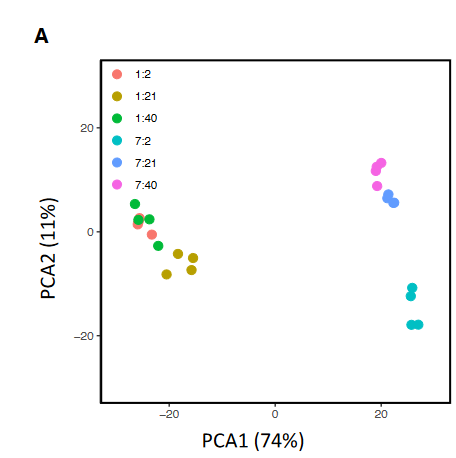

We'll use a variance stablizing transformation before we run the PCA, because that's what it looks like Larry did.

In [42]:
dds.vst()

Fit type used for VST : parametric


Fitting dispersions...
... done in 35.19 seconds.



In [43]:
dds.layers["vst_counts"].shape

(24, 40932)

In [44]:
X = dds.layers["vst_counts"]
y = counts_df.index.str.split('_').str[:2].str.join('_')

pca = PCA(n_components=2)
X_r = pca.fit(X).transform(X)

{'1h_2o2': array([0.12156863, 0.46666667, 0.70588235, 1.        ]), '7h_40o2': array([0.17254902, 0.62745098, 0.17254902, 1.        ]), '1h_21o2': array([0.58039216, 0.40392157, 0.74117647, 1.        ]), '7h_2o2': array([0.89019608, 0.46666667, 0.76078431, 1.        ]), '7h_21o2': array([0.7372549 , 0.74117647, 0.13333333, 1.        ]), '1h_40o2': array([0.61960784, 0.85490196, 0.89803922, 1.        ])}


<Figure size 640x480 with 0 Axes>

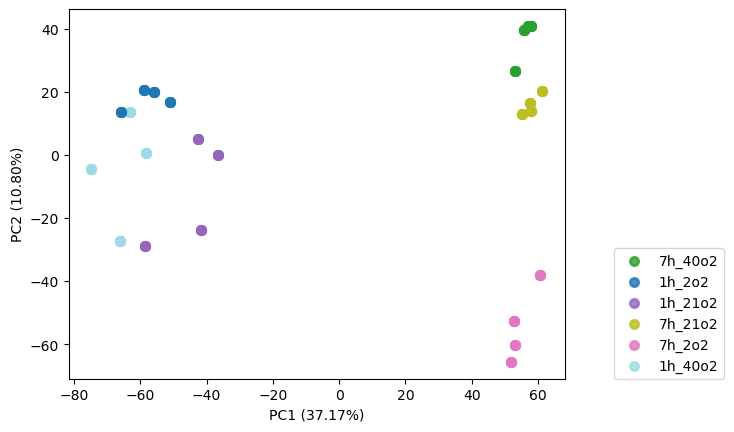

In [45]:
plt.figure()
colors = {i: c for i, c in zip(set(y), plt.cm.tab20(np.linspace(0, 1, len(set(y)))))}
print(colors)
pc1_ex_var, pc2_ex_var = pca.explained_variance_ratio_
lw = 2

fig, ax = plt.subplots(1)
for i in y:
    ax.scatter(
        X_r[y == i, 0], X_r[y == i, 1], color=colors[i], alpha=0.8, lw=lw, label=i
    )
ax.set_xlabel(f'PC1 ({pc1_ex_var*100:.2f}%)')
ax.set_ylabel(f'PC2 ({pc2_ex_var*100:.2f}%)')

def legend_without_duplicate_labels(ax):
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles[::-1], labels[::-1])) if l not in labels[::-1][:i]]
    ax.legend(*zip(*unique), loc=(1.1,0))
legend_without_duplicate_labels(ax)

The explained variance is vastly different than in the plot we're trying to reproduce, however, very encouragingly we see the similar trends in separation! At least we do in the fact that PC1 explains the variance between timepoints, and that the 1 hour samples are not very different from one another.

## DE statistical analysis

For the moment, we're going to filter out the 1h timepoints in the interest of reproducing the original analysis; we can come back and do 1h vs 7h per condition later on if we're interested in doing so. We then need to re-run the modeling component again before doing the statistical analysis:

In [46]:
samples_to_keep = metadata[metadata['hour'] == '7h'].index
metadata = metadata.loc[samples_to_keep]
counts_df = counts_df.loc[samples_to_keep]
print(metadata.shape, counts_df.shape)

(12, 2) (12, 40932)


In [47]:
inference = DefaultInference(n_cpus=8)
dds = DeseqDataSet(
    counts=counts_df,
    metadata=metadata,
    design='~hour+o2+hour:o2',
    inference=inference,
)
dds.deseq2()

Fitting size factors...
... done in 0.02 seconds.



Using None as control genes, passed at DeseqDataSet initialization


Fitting dispersions...
... done in 29.12 seconds.

Fitting dispersion trend curve...
... done in 0.76 seconds.

Fitting MAP dispersions...
... done in 29.32 seconds.

Fitting LFCs...
... done in 24.24 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.



In [48]:
ds_2_vs_21 = DeseqStats(
    dds,
    contrast=['o2', '2o2', '21o2'],
    alpha=0.05
)

In [49]:
ds_2_vs_21.summary()

Running Wald tests...


Log2 fold change & Wald test p-value: o2 2o2 vs 21o2
             baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
AT1G01010   23.358701       -0.062209  0.554680 -0.112153  0.910702  0.963846
AT1G01020  163.479189        0.415435  0.148858  2.790817  0.005258  0.028541
AT1G03987    0.733937       -0.475523  2.587452 -0.183780  0.854186       NaN
AT1G01030   71.655538        0.125704  0.248579  0.505690  0.613074  0.797677
AT1G01040   88.012358       -0.213601  1.367626 -0.156184  0.875888  0.946671
...               ...             ...       ...       ...       ...       ...
ATMG01390  899.521943       -0.193056  0.131629 -1.466664  0.142468  0.329994
G38195       0.000000             NaN       NaN       NaN       NaN       NaN
ATMG01400   11.787260        1.038683  0.671670  1.546419  0.122003  0.298308
G38197       4.595019       -0.453457  4.261995 -0.106395  0.915269  0.965562
ATMG01410   22.829872        0.044851  0.405903  0.110498  0.912015  0.964667

[40932 row

... done in 197.14 seconds.



In [50]:
DE_2_vs_21 = ds_2_vs_21.results_df
DE_2_vs_21.head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
AT1G01010,23.358701,-0.062209,0.554680,-0.112153,0.910702,0.963846
AT1G01020,163.479189,0.415435,0.148858,2.790817,0.005258,0.028541
AT1G03987,0.733937,-0.475523,2.587452,-0.183780,0.854186,NaN
AT1G01030,71.655538,0.125704,0.248579,0.505690,0.613074,0.797677
AT1G01040,88.012358,-0.213601,1.367626,-0.156184,0.875888,0.946671


In [51]:
ds_40_vs_21 = DeseqStats(
    dds,
    contrast=['condition', '40o2', '21o2'],
    alpha=0.05
)

ValueError: You specified a variable that is not part of the model. Available variables: hour,o2

In [ ]:
ds_40_vs_21.summary()

In [ ]:
DE_40_vs_21 = ds_40_vs_21.results_df
DE_40_vs_21.head()

## Number of DE genes at conditions

Reproducing the following plot (all samples are from 7h):

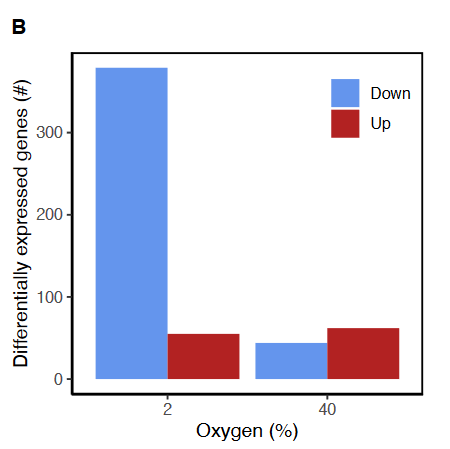

In [ ]:
two_up = DE_2_vs_21[(DE_2_vs_21["padj"] < 0.05) & (DE_2_vs_21["log2FoldChange"] > 0)]
two_down = DE_2_vs_21[(DE_2_vs_21["padj"] < 0.05) & (DE_2_vs_21["log2FoldChange"] < 0)]
forty_up = DE_40_vs_21[(DE_2_vs_21["padj"] < 0.05) & (DE_40_vs_21["log2FoldChange"] > 0)]
forty_down = DE_40_vs_21[(DE_2_vs_21["padj"] < 0.05) & (DE_40_vs_21["log2FoldChange"] < 0)]

In [ ]:
conditions = ('2', '40')
values = {
    'Up': (len(two_up), len(forty_up)),
    'Down': (len(two_down), len(forty_down))
}

x = np.arange(len(conditions))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in values.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1
ax.set_ylabel('Differentially expressed genes at 7h (#)')
ax.set_xlabel('Oxygen (%)')
ax.set_xticks(x + width, conditions)
ax.legend(loc='upper left', ncols=3)

Well that is very different, but to a level that makes me think I probably did something obvious wrong, although I'm not sure what that might be.